In [1]:
import pandas as pd
import os
import datetime
import dateparser
import numpy as np
from dotenv import load_dotenv
import json
from tqdm import tqdm
import string

from mistralai import Mistral
from datasets import load_dataset
from huggingface_hub import login
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

from pydantic import BaseModel, Field
from typing import List, Optional, get_origin, get_args, Union
from langchain.output_parsers import PydanticOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, BooleanType, TimestampType, StructField, StructType
from pyspark.sql.functions import count


from utils.mongodb_utils import read_bronze_table_as_pyspark, read_bronze_table_as_pandas

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SOURCE

In [2]:
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")
df = dataset["train"].to_pandas()


In [3]:
load_dotenv()
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")

In [4]:
mistral = Mistral(api_key=os.environ.get("MISTRAL_API_KEY"))


Generate random snapshot dates

In [410]:
# Create a seeded Generator
rng = np.random.default_rng(seed=42)

# Define start and end date
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2025-01-01')

# Generate random timestamps between start_date and end_date
random_dates = pd.to_datetime(
    rng.uniform(start_date.value, end_date.value, size=len(df))
)

# Ensure it's treated as a pandas Series and convert to date
df['snapshot_date'] = pd.Series(random_dates).dt.date  # This will convert to date format

Generate random IDs

In [ ]:
def generate_random_id(prefix: str, length=8, use_digits=True, use_letters=True, seed=42):
    rng = np.random.default_rng(seed=seed) 

    characters = ''
    
    if use_digits:
        characters += string.digits
    if use_letters:
        characters += string.ascii_letters

    # Ensure we have characters to choose from
    if not characters:
        raise ValueError("At least one of 'use_digits' or 'use_letters' must be True.")
    
    # Use np.random.choice to randomly select characters
    random_id = ''.join(rng.choice(list(characters), size=length))
    return prefix + random_id

In [ ]:
df['resume_id'] = df.apply(lambda row: generate_random_id('RES_', seed=row.name), axis=1)
df['job_id'] = df.apply(lambda row: generate_random_id('JD_', seed=row.name), axis=1)

# BRONZE TABLE

## Resume Feature Extraction

In [ ]:
# Define models
    
class Experience(BaseModel):
    role: Optional[str] = Field(None, description="The job title or position held")
    company: Optional[str] = Field(None, description="The name of the company. Exclude other description or location")
    date_start: Optional[str] = Field(None, description="The start date of the job. Dates must be in ISO 8601 format (YYYY-MM-DDTHH:MM:SS) or use the keywords 'present', 'current', or 'ongoing'")
    date_end: Optional[str] = Field(None, description="The end date of the job. Dates must be in ISO 8601 format (YYYY-MM-DDTHH:MM:SS) or use the keywords 'present', 'current', or 'ongoing'")
    role_description: Optional[str] = Field(None, description="A description of the responsibilities and achievements in the role")

class Education(BaseModel):
    degree: Optional[str] = Field(None, description="The academic degree obtained")
    institution: Optional[str] = Field(None, description="The name of the educational institution")
    date_start: Optional[str] = Field(None, description="The start date of the education program. Dates must be in ISO 8601 format (YYYY-MM-DDTHH:MM:SS) or use the keywords 'present', 'current', or 'ongoing'")
    date_end: Optional[str] = Field(None, description="The end date of the education program. Dates must be in ISO 8601 format (YYYY-MM-DDTHH:MM:SS) or use the keywords 'present', 'current', or 'ongoing'")
    grade: Optional[float] = Field(None, description="The GPA or final grade, if available")
    description: Optional[str] = Field(None, description="Additional details about the education")

class Resume(BaseModel):
    name: Optional[str] = Field(None, description="Full name of the person")
    location_preference: Optional[str] = Field(None, description="Preference for their work location / remote, if stated")
    work_authorizaton: Optional[str] = Field(None, description="Work authorization that the person holds, such as citizenship, if stated")
    employment_type_preference: Optional[str] = Field(
        None,
        description="Type of employment the resume is looking for such as Full-time, Part-time, Contract, Freelance, or Internship, if stated. It can also be a preference for remote work or on-site work"
    )
    hard_skills: List[str] = Field(default_factory=list, description="A list of hard or technical skills mentioned in the resume. All hard skills are tools, frameworks, or programming languages (e.g., Python, TensorFlow, Docker). Keep it as keywwords. Exclude certification or license")
    soft_skills: List[str] = Field(default_factory=list, description="A list of soft skills mentioned in the resume. Soft skills are qualities like communication, teamwork, leadership. Keep it as keywwords. Exclude required languages")
    languages: List[str]= Field(default_factory=list, description="A list of language proficiencies mentioned in the resume. If the resume does not mention any languages, then fill this with the language that the resume is written in")
    experience: List[Experience] = Field(default_factory=list, description="A list of past work experiences in reverse chronological order (most recent first).")
    education: List[Education] = Field(default_factory=list, description="A list of educational qualifications")
    certifications: List[str] = Field(default_factory=list, description="A list of certifications or licenses related with hard skills, medical skills, and software tools mentioned in the resume. For example, AWS Certified Solutions Architect, PMP, etc. Certifications must exclude any work role IDs, only include valid licenses or certifications.")

# Create the parser
resume_parser = PydanticOutputParser(pydantic_object=Resume)
format_instructions = resume_parser.get_format_instructions()

## Job Desc Feature Extraction

In [ ]:
# Define models for job desc

class JD(BaseModel):
    company_name: Optional[str] = Field(None, description="Name of the company posting the job")
    role_title: Optional[str] = Field(None, description="Job title or position being offered")
    application_deadline: Optional[str] = Field(None, description="The deadline for submitting applications. Dates must be in ISO 8601 format (YYYY-MM-DDTHH:MM:SS)")
    date_posted: Optional[str] = Field(None, description="The date when the job was posted. Dates must be in ISO 8601 format (YYYY-MM-DDTHH:MM:SS)")
    employment_type: Optional[str] = Field(None, description="Type of employment, such as Full-time, Part-time, Contract, Freelance, or Internship. If not stated, it is assumed to be Full-time")
    about_the_company: Optional[str] = Field(None, description="A brief overview or description of the company")
    job_responsibilities: List[str] = Field(default_factory=list, description="A list of key duties, tasks, or responsibilities associated with the job")
    required_hard_skills: List[str] = Field(default_factory=list, description="A list of technical or hard skills required or preferred for the job. Keep it as keywords. This includes programming languages, software tools, or frameworks like Python, Java, SQL")
    required_soft_skills: List[str] = Field(default_factory=list, description="A list of soft skills or character required or preferred for the job. Keep it as keywords. This includes communication, teamwork, or leadership skills")   
    required_language_proficiencies: List[str] = Field(default_factory=list, description="A list of language proficiencies required for the job if stated. If the job description does not mention any languages, then fill this with the language that the job description is written in")
    required_education: Optional[str] = Field(None, description="The minimum educational qualification required for the job, such as a degree or certification")
    required_work_authorization: Optional[str] = Field(None, description="Work authorization required for the job")
    job_location: Optional[str] = Field(None, description="Location where the job is based, such as a city or remote")
    certifications: List[str] = Field(default_factory=list, description="A list of certifications or licenses related with hard skills, medical skills, and software tools mentioned in the resume. certifications should relate only to verifiable credentials (e.g., AWS, CISSP, PMP). Do not include work roles or job titles as certifications")
    
# Create the parser
jd_parser = PydanticOutputParser(pydantic_object=JD)
format_instructions = jd_parser.get_format_instructions()

## Parse


### Parse resume

In [ ]:
# model options

models = mistral.models.list()
for m in models.data:
    print(m.id)


In [ ]:
import json

def parse_with_mistral(text: str, parser, format_instructions: str, label: str) -> BaseModel:

    prompt = (
    f"Parse the following text into a structured format according to the provided schema."
    f"If the same role at the same company appears more than once, merge the role descriptions and preserve the earliest start and latest end dates."
    f"{format_instructions}\n\n"
    f"{label}:\n{text}"
)

    response = mistral.chat.complete(
        model="mistral-medium-latest",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=2048
    )
    raw = response.choices[0].message.content
    return parser.parse(raw)

In [ ]:
resume_text = df["resume_text"].iloc[6236]
parsed_resume = parse_with_mistral(resume_text, resume_parser, resume_parser.get_format_instructions(), "Resume")


In [ ]:
print(parsed_resume.model_dump_json(indent=2))

### Parse job desc

In [ ]:
print(df['job_description_text'].iloc[6236])

In [ ]:
parsed_jd = parse_with_mistral(df['job_description_text'].iloc[6236], jd_parser, jd_parser.get_format_instructions(), "Job Description")

In [ ]:
print(parsed_jd.model_dump_json(indent=2))

### Parse 10 rows

In [ ]:
df_subset = pd.concat([df[:5], df[-5:]])
df_subset

In [ ]:
for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    resume_text = row['resume_text']
    jd_text = row['job_description_text']
    
    try:
        # Process resume
        parsed_resume = parse_with_mistral(
            resume_text,
            resume_parser,
            resume_parser.get_format_instructions(),
            "Resume"
        )
        parsed_resume_dict = parsed_resume.model_dump(mode="json")
        resume_output_path = os.path.join('examples_mistral', 'resume', f"{idx}.json")
        os.makedirs(os.path.dirname(resume_output_path), exist_ok=True) 
        with open(resume_output_path, "w") as f:
            json.dump(parsed_resume_dict, f, indent=2)

        # Process JD
        parsed_jd = parse_with_mistral(
            jd_text,
            jd_parser,
            jd_parser.get_format_instructions(),
            "Job Description"
        )
        parsed_jd_dict = parsed_jd.model_dump(mode="json")
        jd_output_path = os.path.join('examples_mistral', 'jd', f"{idx}.json")
        os.makedirs(os.path.dirname(jd_output_path), exist_ok=True) 
        with open(jd_output_path, "w") as f:
            json.dump(parsed_jd_dict, f, indent=2)

    except Exception as e:
        print(f"Error parsing row {idx}: {e}")

# Connecting to MongoDB

In [5]:
uri = os.environ.get("MONGO_DB_URL")

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [6]:
load_dotenv()

mongo_db_url = os.environ.get("MONGO_DB_URL")

spark = SparkSession.builder \
    .appName("MongoDBIntegration") \
    .config("spark.mongodb.read.connection.uri", mongo_db_url) \
    .config("spark.mongodb.write.connection.uri", mongo_db_url) \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.2.0") \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-acc237fe-a7b6-400c-bd71-8f137a09e14f;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.2.0 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
:: resolution report :: resolve 3629ms :: artifacts dl 15ms
	:: modules in use:
	org.mongodb#bson;4.8.2 from central in [default]
	org.mongodb#bson-record-codec;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-core;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-sync;4.8.2 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;10.2.0 f

### Save in mongodb per item (incrementing table)

In [ ]:
db = client["jobmirror_db"]
resume_collection = db["resumes"]
jd_collection = db["job_descriptions"]

for idx, row in tqdm(df.iterrows(), total=len(df)):
    resume_text = row['resume_text']
    jd_text = row['job_description_text']
    try:
        # Process resume
        parsed_resume = parse_with_mistral(
            resume_text,
            resume_parser,
            resume_parser.get_format_instructions(),
            "Resume"
        )
        parsed_resume_dict = parsed_resume.model_dump(mode="json")
        parsed_resume_dict["row_idx"] = idx  
        resume_collection.insert_one(parsed_resume_dict) 

        # Process JD
        parsed_jd = parse_with_mistral(
            jd_text,
            jd_parser,
            jd_parser.get_format_instructions(),
            "Job Description"
        )
        parsed_jd_dict = parsed_jd.model_dump(mode="json")
        parsed_jd_dict["row_idx"] = idx  
        jd_collection.insert_one(parsed_jd_dict)

    except Exception as e:
        print(f"Error parsing row {idx}: {e}")

In [ ]:
# Clear collections

db = client["jobmirror_db"]
resume_collection = db["resumes"]
jd_collection = db["job_descriptions"]

resume_collection.delete_many({})
jd_collection.delete_many({})



Convert into PySpark Dataframe (Overwrite table)

In [ ]:
def python_type_to_spark_type(annotation):
    origin = get_origin(annotation)

    if origin is Union:  # Handle Optional
        args = [arg for arg in get_args(annotation) if arg is not type(None)]
        return python_type_to_spark_type(args[0])

    if origin in (list, List):
        element_type = python_type_to_spark_type(get_args(annotation)[0])
        return ArrayType(element_type)

    if isinstance(annotation, type):
        if issubclass(annotation, BaseModel):
            return pydantic_to_spark_schema(annotation)
        if issubclass(annotation, str):
            return StringType()
        if issubclass(annotation, int):
            return IntegerType()
        if issubclass(annotation, float):
            return FloatType()
        if issubclass(annotation, bool):
            return BooleanType()
        if issubclass(annotation, datetime.datetime):
            return StringType()

    return StringType()

def pydantic_to_spark_schema(model: type) -> StructType:
    fields = []

    for name, field in model.model_fields.items():
        annotation = field.annotation

        spark_type = python_type_to_spark_type(annotation)
        fields.append(StructField(name, spark_type, True))  # assume all nullable
    fields.append(StructField('snapshot_date', StringType(), True))
    fields.append(StructField('id', StringType(), True))

    return StructType(fields)

In [ ]:
parsed_resumes = []
parsed_jds = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Parse resume
        parsed_resume = parse_with_mistral(
            row['resume_text'],
            resume_parser,
            resume_parser.get_format_instructions(),
            "Resume"
        )
        parsed_resume_dict = parsed_resume.model_dump(mode="json")
        parsed_resume_dict['snapshot_date'] = row['snapshot_date']
        parsed_resume_dict['id'] = row['resume_id']
        parsed_resumes.append(parsed_resume_dict)

        # Parse JD
        parsed_jd = parse_with_mistral(
            row['job_description_text'],
            jd_parser,
            jd_parser.get_format_instructions(),
            "Job Description"
        )
        parsed_jd_dict = parsed_jd.model_dump(mode="json")
        parsed_jd_dict['snapshot_date'] = row['snapshot_date']
        parsed_jd_dict['id'] = row['job_id']
        parsed_jds.append(parsed_jd_dict)
    except Exception as e:
        print(f"Error parsing row {idx}: {e}")

In [ ]:
resume_schema = pydantic_to_spark_schema(Resume)
jd_schema = pydantic_to_spark_schema(JD)

resume_df = spark.createDataFrame(parsed_resumes, schema=resume_schema)
jd_df = spark.createDataFrame(parsed_jds, schema=jd_schema)


In [ ]:
read_bronze_table_as_pyspark("jobmirror_db", "bronze_resumes")

Load data from database

In [ ]:
df_bronze_resume = read_bronze_table_as_pandas("jobmirror_db", "bronze_resumes")
print(df_bronze_resume.head())

In [ ]:
df_bronze_resume.info()

In [ ]:
df_bronze_jd = read_bronze_table_as_pandas("jobmirror_db", "bronze_job_descriptions")
print(df_bronze_jd.head())

In [ ]:
df_bronze_jd.info()

In [ ]:
df_bronze_label = read_bronze_table_as_pandas("jobmirror_db", "bronze_labels")
print(df_bronze_label.head())

In [ ]:
df_bronze_label.info()

In [ ]:
collection = client["jobmirror_db"]["bronze_resume"]

In [ ]:
pipeline = [
    {
        "$group": {
            "_id": "$id",                  # Field to check duplicates on
            "ids": { "$addToSet": "$_id" },   # Collect all document IDs for this email
            "count": { "$sum": 1 }
        }
    },
    {
        "$match": {
            "count": { "$gt": 1 }             # Only duplicates
        }
    }
]

duplicates = collection.aggregate(pipeline)

# Step 2: Delete all but one document for each duplicate
for doc in duplicates:
    ids = doc["ids"]
    ids_to_delete = ids[1:]  # Keep the first one, delete the rest
    if ids_to_delete:
        result = collection.delete_many({ "_id": { "$in": ids_to_delete } })

In [ ]:
from pymongo import MongoClient


db = client["jobmirror_db"]

result = db.bronze_resumes.update_many(
    {},  # filter: apply to all documents
    {"$rename": {"work_authorizaton": "work_authorization"}}
)

print(f"Matched {result.matched_count} documents and modified {result.modified_count} documents.")


## Skills Feature Extraction

In [402]:
import os.path
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow

from google.oauth2 import service_account
from googleapiclient.discovery import build

creds = service_account.Credentials.from_service_account_file(
    'service_account.json',
    scopes=['https://www.googleapis.com/auth/drive.readonly']
)

service = build('drive', 'v3', credentials=creds)





In [ ]:
from googleapiclient.http import MediaIoBaseDownload
import io

def list_folder_contents(service, folder_id, parent_path=''):
    all_files = []

    query = f"'{folder_id}' in parents and trashed = false"
    results = service.files().list(q=query,
                                   fields="files(id, name, mimeType)").execute()
    items = results.get('files', [])

    for item in items:
        file_path = os.path.join(parent_path, item['name'])

        if item['mimeType'] == 'application/vnd.google-apps.folder':
            # Recurse into subfolder
            all_files.extend(list_folder_contents(service, item['id'], file_path))
        else:
            # Add file to list
            all_files.append({
                'id': item['id'],
                'name': item['name'],
                'mimeType': item['mimeType'],
                'path': file_path
            })

    return all_files

def download_file(service, file, output_base):
    os.makedirs(os.path.dirname(os.path.join(output_base, file['path'])), exist_ok=True)
    file_path = os.path.join(output_base, file['path'])

    export_formats = {
        'application/vnd.google-apps.document': 'application/pdf',
        'application/vnd.google-apps.spreadsheet': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet',
        'application/vnd.google-apps.presentation': 'application/pdf',
    }

    if file['mimeType'] in export_formats:
        # Export Google Docs formats
        request = service.files().export_media(
            fileId=file['id'],
            mimeType=export_formats[file['mimeType']]
        )
        file_path += get_file_extension(export_formats[file['mimeType']])
    else:
        # Binary files
        request = service.files().get_media(fileId=file['id'])

    with io.FileIO(file_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()

def get_file_extension(mime_type):
    mapping = {
        'application/pdf': '.pdf',
        'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet': '.xlsx',
        'application/vnd.openxmlformats-officedocument.wordprocessingml.document': '.docx',
    }
    return mapping.get(mime_type, '')

files = list_folder_contents(service, '1_eMgnRaFtt-ZSZD3zfwai3qlpYJ-M5C6')

for f in tqdm(files, total=len(files), desc="Downloading data files..."):
    download_file(service, f, '.')
print("Download complete.")


In [ ]:
# Load skills data
import pandas as pd

# Example: View the Skills.xlsx file
activity_skills_path = r'datamart/bronze/skills/Skills to Work Activities.xlsx'
activity_skills_df = pd.read_excel(activity_skills_path)
print(activity_skills_df.head(5))



In [ ]:
context_skills_path = r'datamart/bronze/skills/Skills to Work Context.xlsx'
context_skills_df = pd.read_excel(context_skills_path)
print(context_skills_df.head(5))


In [ ]:
skills_path = r'datamart/bronze/skills/Skills.xlsx'
skills_df = pd.read_excel(skills_path)
print(skills_df.head(5))


In [ ]:
tech_skills_path = r'datamart/bronze/skills/Technology Skills.xlsx'
tech_skills_df = pd.read_excel(tech_skills_path)
print(tech_skills_df.head(5))

# SILVER

In [ ]:
from google.oauth2 import service_account
from googleapiclient.discovery import build
import os
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
import io
from io import BytesIO
import pandas as pd
import pyarrow.parquet as pq



## Resume

In [5]:
df_silver_jd = read_bronze_table_as_pyspark("jobmirror_db", "bronze_job_descriptions")
df_silver_resume = read_bronze_table_as_pyspark("jobmirror_db", "bronze_resumes")

df_silver_label = read_bronze_table_as_pyspark("jobmirror_db", "bronze_labels")

:: loading settings :: url = jar:file:/usr/local/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-20359fb1-d143-4624-8de4-997462cec5a9;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.5.0 in central
	found org.mongodb#mongodb-driver-sync;5.1.4 in central
	[5.1.4] org.mongodb#mongodb-driver-sync;[5.1.1,5.1.99)
	found org.mongodb#bson;5.1.4 in central
	found org.mongodb#mongodb-driver-core;5.1.4 in central
	found org.mongodb#bson-record-codec;5.1.4 in central
:: resolution report :: resolve 2085ms :: artifacts dl 6ms
	:: modules in use:
	org.mongodb#bson;5.1.4 from central in [default]
	org.mongodb#bson-record-codec;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-core;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-sync;5.1.4 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;10.5.0 fr

In [6]:
df_silver_resume.printSchema()



root
 |-- _id: string (nullable = true)
 |-- certifications: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- education: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- degree: string (nullable = true)
 |    |    |-- institution: string (nullable = true)
 |    |    |-- date_start: string (nullable = true)
 |    |    |-- date_end: string (nullable = true)
 |    |    |-- grade: double (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- snapshot_date: void (nullable = true)
 |    |    |-- id: void (nullable = true)
 |-- employment_type_preference: string (nullable = true)
 |-- experience: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- role: string (nullable = true)
 |    |    |-- company: string (nullable = true)
 |    |    |-- date_start: string (nullable = true)
 |    |    |-- date_end: string (nullable = true)
 |    |    |-- role_description: stri

In [7]:
df_resume_label_joined = df_silver_resume.join(
    df_silver_label,
    df_silver_resume["id"] == df_silver_label["resume_id"],
    how="inner"
)

df_resume_label_joined.show(5)

[Stage 0:>                                                          (0 + 1) / 1]

+--------------------+--------------+--------------------+--------------------------+--------------------+--------------------+------------+-----------------+-------------------+----+-------------+--------------------+------------------+--------------------+-------------+--------------+-----------+------------+-------------+
|                 _id|certifications|           education|employment_type_preference|          experience|         hard_skills|          id|        languages|location_preference|name|snapshot_date|         soft_skills|work_authorization|                 _id|          fit|            id|     job_id|   resume_id|snapshot_date|
+--------------------+--------------+--------------------+--------------------------+--------------------+--------------------+------------+-----------------+-------------------+----+-------------+--------------------+------------------+--------------------+-------------+--------------+-----------+------------+-------------+
|683f3ae880dcaf129.

#### employment type

In [372]:
employment_counts = df_resume_label_joined['employment_type_preference'].value_counts(dropna=False)
print("Employment Type Preference Counts:")
print(employment_counts)


Employment Type Preference Counts:
employment_type_preference
None                        5937
Full-time                    143
Internship                    79
Contract                      21
full-time                     13
Full time / Part Time         10
part-time                     10
full time                      8
remote flexible schedule       7
Full-time or Part-time         5
flexible schedule              3
part-time or full-time         2
FTE positions                  1
FTE                            1
Intern                         1
Name: count, dtype: int64


In [9]:
employment_counts = df_resume_label_joined.groupBy("employment_type_preference").agg(
    count("*").alias("count")
)

print("Employment Type Preference Counts:")
employment_counts.show()

Employment Type Preference Counts:
+--------------------------+-----+
|employment_type_preference|count|
+--------------------------+-----+
|      Full-time or Part...|    5|
|                      NULL| 5937|
|                    Intern|    1|
|             FTE positions|    1|
|                  Contract|   21|
|                 full time|    8|
|                       FTE|    1|
|      part-time or full...|    2|
|      remote flexible s...|    7|
|                 full-time|   13|
|                 Full-time|  143|
|                 part-time|   10|
|      Full time / Part ...|   10|
|         flexible schedule|    3|
|                Internship|   79|
+--------------------------+-----+



In [373]:
def clean_employment_type(val):
    if pd.isna(val):
        return 'full-time' \
    
    val = str(val).lower()  \

    if any(keyword in val for keyword in ['full', 'remote', 'flexible', 'fte']):
        return 'full-time'
    elif 'part' in val:
        return 'part-time'
    elif 'intern' in val:
        return 'internship'
    elif 'contract' in val:
        return 'contract'
    else:
        return 'full-time'  

# Apply the function
df_resume_label_joined['employment_type_preference_cleaned'] = df_resume_label_joined['employment_type_preference'].apply(clean_employment_type)

# Check new counts
print(df_resume_label_joined['employment_type_preference_cleaned'].value_counts())


employment_type_preference_cleaned
full-time     6130
internship      80
contract        21
part-time       10
Name: count, dtype: int64


In [10]:
# In pyspark 
from pyspark.sql.functions import col, when, lower
from pyspark.sql import DataFrame
from utils.data_cleaning_utils import clean_employment_type_column


df_resume_label_joined = clean_employment_type_column(df_resume_label_joined, "employment_type_preference")

# Check new counts
df_resume_label_joined.groupBy("employment_type_preference_cleaned") \
    .agg(count("*").alias("count")) \
    .show()


+----------------------------------+-----+
|employment_type_preference_cleaned|count|
+----------------------------------+-----+
|                          contract|   21|
|                        internship|   80|
|                         full-time| 6130|
|                         part-time|   10|
+----------------------------------+-----+



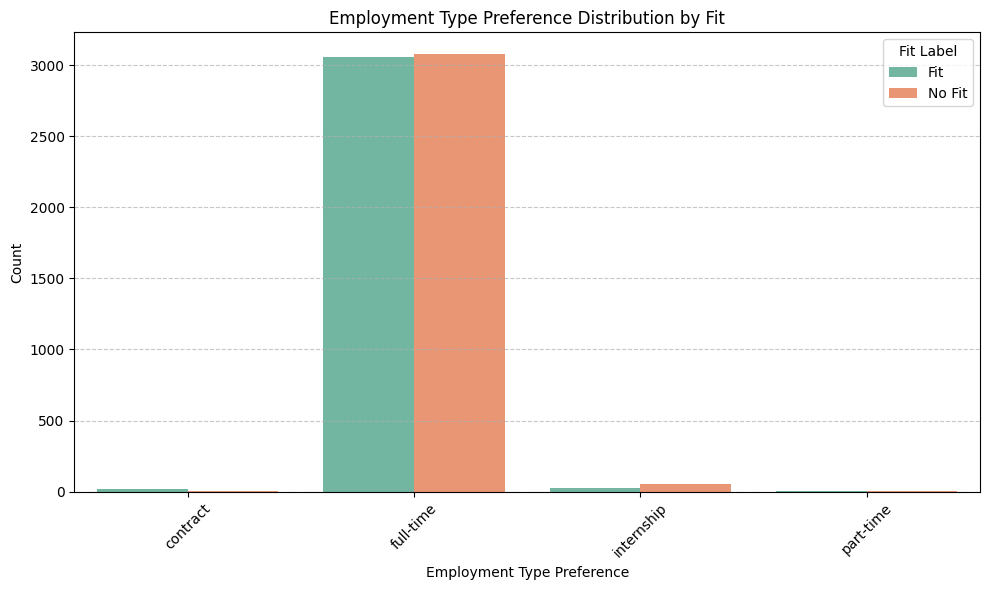

In [374]:
import seaborn as sns

# Group and count the data
group_counts = df_resume_label_joined.groupby(['employment_type_preference_cleaned', 'fit_grouped']).size().reset_index(name='counts')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=group_counts, 
            x='employment_type_preference_cleaned', 
            y='counts', 
            hue='fit_grouped', 
            palette='Set2')

plt.title('Employment Type Preference Distribution by Fit')
plt.xlabel('Employment Type Preference')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit Label')
plt.tight_layout()
plt.show()

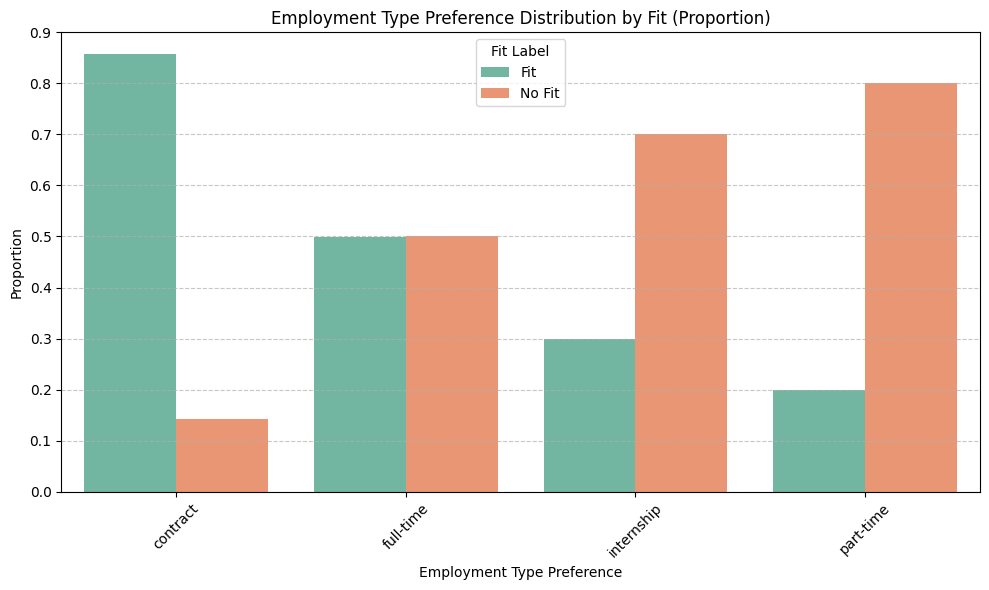

In [375]:
# Group and count the data
group_counts = df_resume_label_joined.groupby(['employment_type_preference_cleaned', 'fit_grouped']).size().reset_index(name='counts')

# Calculate total counts per employment type
total_counts = group_counts.groupby('employment_type_preference_cleaned')['counts'].transform('sum')

# Calculate ratio
group_counts['ratio'] = group_counts['counts'] / total_counts

# Plot ratio with seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=group_counts,
            x='employment_type_preference_cleaned',
            y='ratio',
            hue='fit_grouped',
            palette='Set2')

plt.title('Employment Type Preference Distribution by Fit (Proportion)')
plt.xlabel('Employment Type Preference')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit Label')
plt.tight_layout()
plt.show()


#### location preference 

In [ ]:
location_pref_counts = df_resume_label_joined['location_preference'].value_counts(dropna=False)
print("Location Type Preference Counts:")
print(location_pref_counts)


In [14]:

location_pref_counts = df_resume_label_joined.groupBy("location_preference").agg(
    count("*").alias("count")
)

print("Location Type Preference Counts:")
location_pref_counts.show()


Location Type Preference Counts:
+--------------------+-----+
| location_preference|count|
+--------------------+-----+
|Chicago, IL or De...|   22|
|              Remote|    1|
|Minneapolis/St Pa...|    2|
|                NULL| 6095|
| Willing to relocate|   10|
|                 WFH|   24|
|        Wfh_City, MI|   12|
|            Flexible|    7|
|California or the...|    4|
|remote flexible s...|   13|
|                  UK|   17|
|             Houston|    7|
|   Ready to relocate|   15|
|              remote|   12|
+--------------------+-----+



In [2]:
city_state_list = r'datamart/bronze/location/cities.csv'
city_state_df = pd.read_csv(city_state_list)
print(city_state_df.head(5))

    id       name  state_id state_code  state_name  country_id country_code  \
0   52  Ashkāsham      3901        BDS  Badakhshan           1           AF   
1   68   Fayzabad      3901        BDS  Badakhshan           1           AF   
2   78       Jurm      3901        BDS  Badakhshan           1           AF   
3   84    Khandūd      3901        BDS  Badakhshan           1           AF   
4  115  Rāghistān      3901        BDS  Badakhshan           1           AF   

  country_name  latitude  longitude wikiDataId  
0  Afghanistan  36.68333   71.53333   Q4805192  
1  Afghanistan  37.11664   70.58002    Q156558  
2  Afghanistan  36.86477   70.83421  Q10308323  
3  Afghanistan  36.95127   72.31800   Q3290334  
4  Afghanistan  37.66079   70.67346   Q2670909  


In [377]:
location_lookup = {}
us_country_code = 'US'  # Focus on US states only (data too dirty for now. future prompt engineering is needed)
country_codes = set(city_state_df['country_code'].dropna().unique())

# Build location lookup dictionary for US states only
for idx, row in city_state_df.iterrows():
    if row['country_code'] != us_country_code:  # Skip non-US rows
        continue

    city_name = str(row['name']).strip().lower() if pd.notna(row['name']) else None
    state_code = str(row['state_code']).strip().lower() if pd.notna(row['state_code']) else None
    state_name = str(row['state_name']).strip().lower() if pd.notna(row['state_name']) else None

    if state_code:
        location_lookup[state_code] = row['state_code'] 
    if state_name:
        location_lookup[state_name] = row['state_code']
    if city_name:
        location_lookup[city_name] = row['state_code']


In [378]:
def standardize_location(location_str):
    if pd.isna(location_str):
        return 'Not specified'

    loc = location_str.strip().lower()
    parts = re.split(r',|\bor\b|\/|\band\b', loc)  # split by , or / or and

    for part in parts:
        part = part.strip()

        # Check if the part matches the lookup
        if part in location_lookup:
            return location_lookup[part]

    return 'Not specified'

In [ ]:
# ################# JUST CHECK SAME STATE AND CITY ID 

# for idx, row in city_state_df.iterrows():
#     state_code = row['state_code'].strip().upper() if pd.notna(row['state_code']) else None

#     if not state_code:
#         continue  # skip if state_code is missing

#     # Map city name to state_code
#     if pd.notna(row['name']):
#         location_lookup[row['name'].strip().lower()] = state_code
#     # Map state name to state_code
#     if pd.notna(row['state_name']):
#         location_lookup[row['state_name'].strip().lower()] = state_code


# ############################# INCLUDE ALL STATE AND COUNTRY 

# country_codes = set(city_state_df['country_code'].dropna().unique())

# # build state lookup only (not country)
# location_lookup = {}

# for idx, row in city_state_df.iterrows():
#     city_name = str(row['name']).strip().lower() if pd.notna(row['name']) else None
#     state_code = str(row['state_code']).strip().lower() if pd.notna(row['state_code']) else None
#     state_name = str(row['state_name']).strip().lower() if pd.notna(row['state_name']) else None
#     country_code = str(row['country_code']).strip() if pd.notna(row['country_code']) else None
#     country_name = str(row['country_name']).strip().lower() if pd.notna(row['country_name']) else None
    
#     # Map state code and state name only
#     if state_code:
#         location_lookup[state_code] = row['state_code'] 
#     if state_name:
#         location_lookup[state_name] = row['state_code']


# def standardize_location(location_str):
#     if pd.isna(location_str):
#         return 'Not specified'

#     loc = location_str.strip().lower()

#     # Split the location string by common delimiters
#     parts = re.split(r',|\bor\b|\/|\band\b', loc)

#     for part in parts:
#         part = part.strip()

#         # Skip if part is a known country code
#         if part in country_codes:
#             continue  

#         # Check if the part matches state code or name
#         if part in location_lookup:
#             return location_lookup[part]

#     return 'Not specified'


In [379]:
# Apply to dataframe
df_resume_label_joined['location_standardized'] = df_resume_label_joined['location_preference'].apply(standardize_location)


In [380]:
print("Unique Original Locations:")
print(sorted(df_resume_label_joined['location_preference'].dropna().unique()))

print("\nUnique Standardized Locations:")
print(sorted(df_resume_label_joined['location_standardized'].unique()))



Unique Original Locations:
['California or the Southern United States', 'Chicago, IL or Denver, CO', 'Flexible', 'Houston', 'Minneapolis/St Paul Minnesota area', 'Ready to relocate', 'Remote', 'UK', 'WFH', 'Wfh_City, MI', 'Willing to relocate', 'remote', 'remote flexible schedule']

Unique Standardized Locations:
['IL', 'MI', 'MN', 'Not specified', 'PA', 'TX']


In [8]:
from utils.data_cleaning_utils import location_lookup, standardize_location_column

location_dict = location_lookup(city_state_df)

df_resume_label_joined = standardize_location_column(
    df_resume_label_joined,
    location_col="location_preference",
    location_lookup=location_dict,
)


In [9]:
print("Unique Original Locations:")
original_locations = df_resume_label_joined.select("location_preference") \
    .where(col("location_preference").isNotNull()) \
    .distinct() \
    .orderBy("location_preference") \
    .rdd.flatMap(lambda x: x) \
    .collect()
print(original_locations)

print("\nUnique Standardized Locations:")
standardized_locations = df_resume_label_joined.select("location_preference_cleaned") \
    .where(col("location_preference_cleaned").isNotNull()) \
    .distinct() \
    .orderBy("location_preference_cleaned") \
    .rdd.flatMap(lambda x: x) \
    .collect()
print(standardized_locations)


Unique Original Locations:


['California or the Southern United States', 'Chicago, IL or Denver, CO', 'Flexible', 'Houston', 'Minneapolis/St Paul Minnesota area', 'Ready to relocate', 'Remote', 'UK', 'WFH', 'Wfh_City, MI', 'Willing to relocate', 'remote', 'remote flexible schedule']

Unique Standardized Locations:


[Stage 22:>                                                         (0 + 1) / 1]

['IL', 'MI', 'MN', 'Not specified', 'PA', 'TX']


/tmp/ipykernel_14/4269498042.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', num_classes)  # Use Set1 colormap


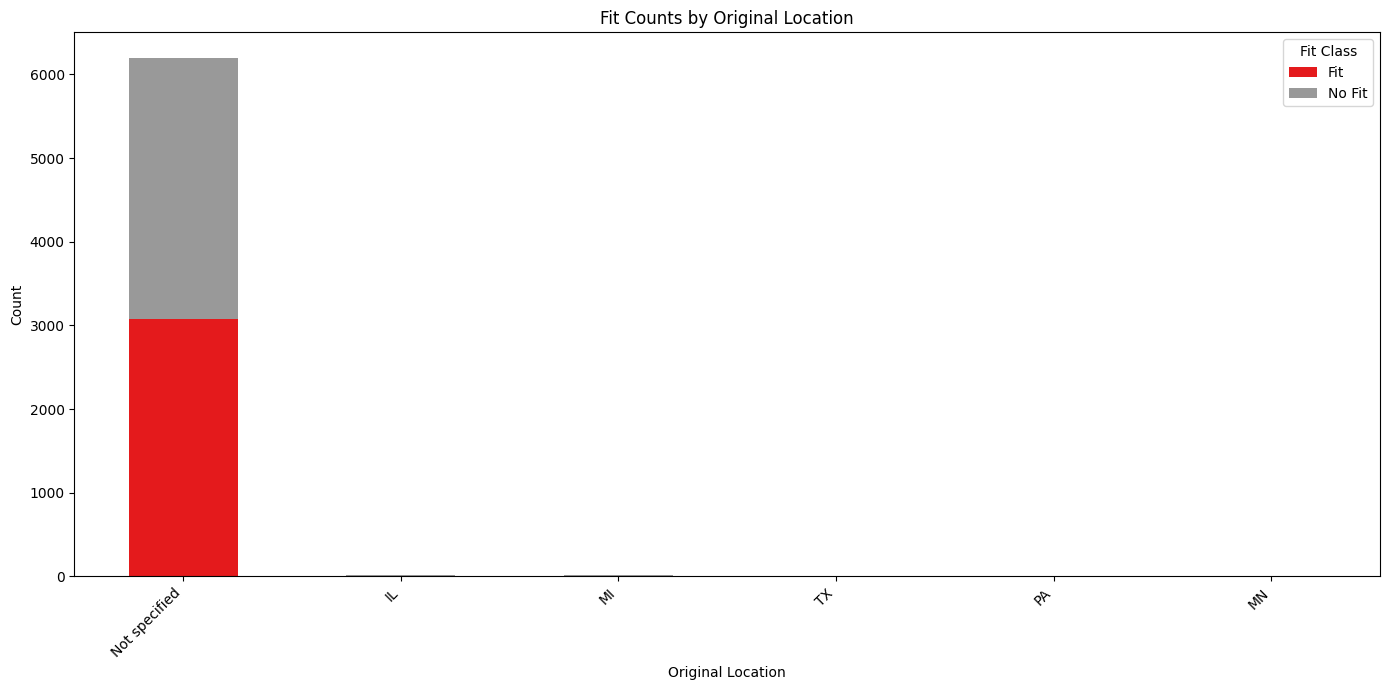

In [381]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fit_counts = df_resume_label_joined.groupby(['location_standardized', 'fit_grouped']).size().unstack(fill_value=0)

# Sort locations by total counts (optional)
fit_counts['total'] = fit_counts.sum(axis=1)
fit_counts = fit_counts.sort_values('total', ascending=False)

fit_classes = fit_counts.columns.drop('total')
num_classes = len(fit_classes)

cmap = cm.get_cmap('Set1', num_classes)  # Use Set1 colormap
colors = [cmap(i) for i in range(num_classes)]

fit_counts[fit_classes].plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    color=colors
)

plt.xlabel('Original Location')
plt.ylabel('Count')
plt.title('Fit Counts by Original Location')
plt.legend(title='Fit Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_14/3631961157.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', num_classes)


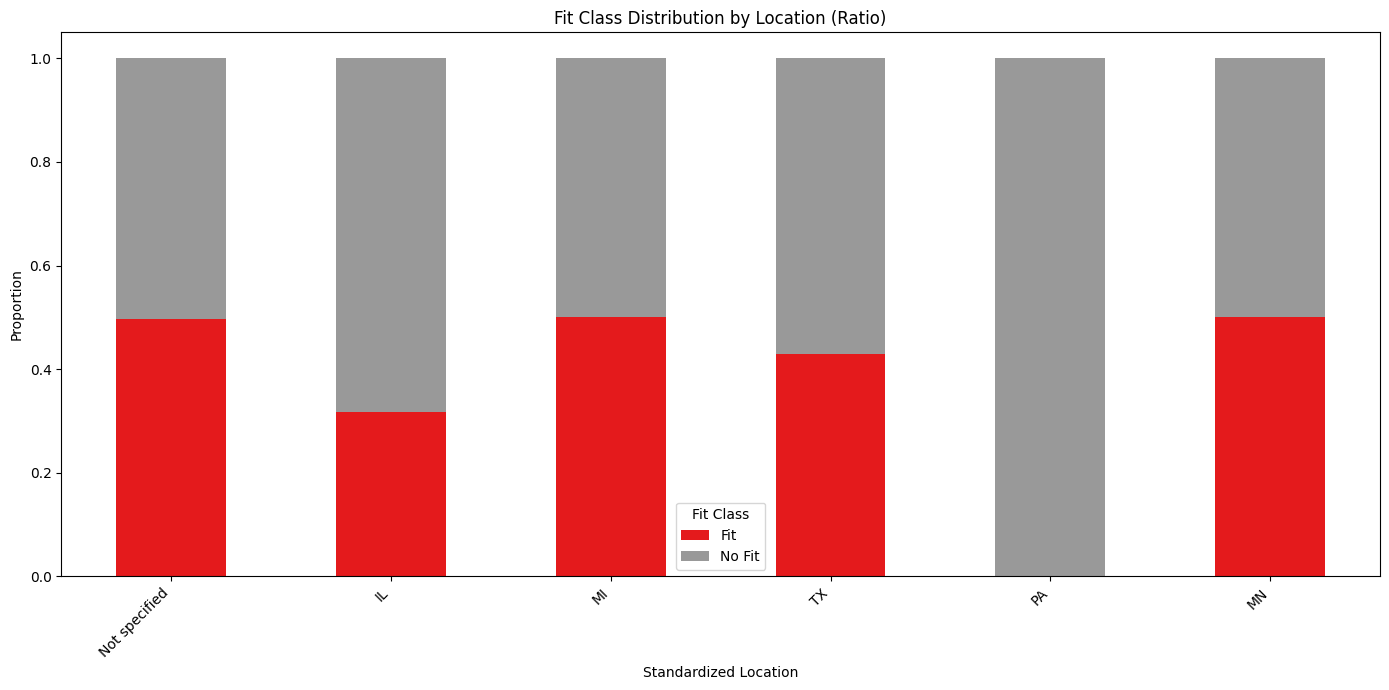

In [382]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fit_counts = df_resume_label_joined.groupby(['location_standardized', 'fit_grouped']).size().unstack(fill_value=0)

fit_counts['total'] = fit_counts.sum(axis=1)
fit_counts = fit_counts.sort_values('total', ascending=False)

fit_classes = fit_counts.columns.drop('total')

# Normalize each row to sum to 1 (ratio)
fit_ratios = fit_counts[fit_classes].div(fit_counts['total'], axis=0)

num_classes = len(fit_classes)
cmap = cm.get_cmap('Set1', num_classes)
colors = [cmap(i) for i in range(num_classes)]

fit_ratios.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    color=colors
)

plt.xlabel('Standardized Location')
plt.ylabel('Proportion')
plt.title('Fit Class Distribution by Location (Ratio)')
plt.legend(title='Fit Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### certification

In [307]:
def count_certifications(x):
    if isinstance(x, float) and pd.isna(x):
        return 0
    elif isinstance(x, list):
        return len(x)
    elif isinstance(x, np.ndarray):
        return len(x)
    elif isinstance(x, str):
        # Split by comma, filter out empty strings
        return len([i for i in x.split(',') if i.strip() != ''])
    else:
        return 0  # fallback for any unexpected type

df_resume_label_joined['certification_count'] = df_silver_resume['certifications'].apply(count_certifications)

print("Sample Certification Counts:")
print(df_resume_label_joined[['resume_id', 'certifications', 'certification_count']].head())


Sample Certification Counts:
      resume_id                                     certifications  \
0  RES_Lrgk1qIc                                                 []   
1  RES_kUoPlNoI                                                 []   
2  RES_s93wTCLp  [ADCO PTW (Permit To-Work) system training cer...   
3  RES_W35SEzlG                                                 []   
4  RES_kQiZZseA                 [Cosmetology License, CNA License]   

   certification_count  
0                    0  
1                    0  
2                    3  
3                    0  
4                    2  


/tmp/ipykernel_14/1392260505.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_resume_label_joined, x='fit', y='certification_count', jitter=True, palette='Set1', edgecolor='gray', linewidth=0.5)
/tmp/ipykernel_14/1392260505.py:5: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_resume_label_joined, x='fit', y='certification_count', jitter=True, palette='Set1', edgecolor='gray', linewidth=0.5)


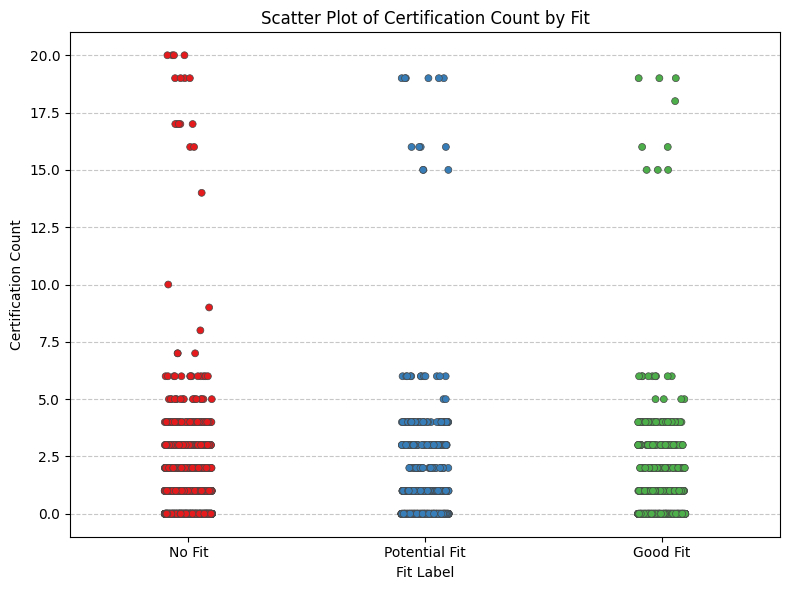

In [308]:
plt.figure(figsize=(8,6))
sns.stripplot(data=df_resume_label_joined, x='fit', y='certification_count', jitter=True, palette='Set1', edgecolor='gray', linewidth=0.5)

plt.title('Scatter Plot of Certification Count by Fit')
plt.xlabel('Fit Label')
plt.ylabel('Certification Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### work authorization

In [309]:
work_auth_counts = df_resume_label_joined['work_authorization'].value_counts(dropna=False)
print("Work Authorization Counts:")
print(work_auth_counts)


Work Authorization Counts:
work_authorization
None                                                               6110
United States Citizen                                                34
US Citizen and authorized to work in the US without sponsorship      24
Valid VISA to work in UK                                             17
H1B Visa                                                             11
Authorized to work in the US for any employer                        11
United States Navy with a Secret security clearance                  10
Authorized to work in US                                              7
Secret security clearance                                             6
H1-B Visa                                                             4
US Citizen                                                            3
Do not require sponsorship                                            3
Secret Security Clearance                                             1
Name: count, dtype

In [10]:
from pyspark.sql.functions import coalesce, lit

# Replace nulls with a string to count them as well (e.g., "null")
df_filled = df_resume_label_joined.withColumn(
    "work_authorization_filled",
    coalesce(col("work_authorization"), lit("null"))
)

work_auth_counts = df_filled.groupBy("work_authorization_filled").count()

print("Work Authorization Counts:")
work_auth_counts.orderBy("count", ascending=False).show(truncate=False)


Work Authorization Counts:
+---------------------------------------------------------------+-----+
|work_authorization_filled                                      |count|
+---------------------------------------------------------------+-----+
|null                                                           |6110 |
|United States Citizen                                          |34   |
|US Citizen and authorized to work in the US without sponsorship|24   |
|Valid VISA to work in UK                                       |17   |
|Authorized to work in the US for any employer                  |11   |
|H1B Visa                                                       |11   |
|United States Navy with a Secret security clearance            |10   |
|Authorized to work in US                                       |7    |
|Secret security clearance                                      |6    |
|H1-B Visa                                                      |4    |
|US Citizen                          

In [ ]:
def standardize_work_authorization(x):
    if pd.isna(x) or str(x).strip().lower() == 'none':
        return 'not needed'

    elif re.search(r'do\s*not\s*require|no\s*sponsorship|none', str(x), re.IGNORECASE):
        return 'not needed'
    else:
        return 'needed'

# Apply to your DataFrame
df_resume_label_joined['work_authorization_cleaned'] = df_resume_label_joined['work_authorization'].apply(standardize_work_authorization)

# Check result
work_auth_counts_cleaned = df_resume_label_joined['work_authorization_cleaned'].value_counts()
print("Standardized Work Authorization Counts:")
print(work_auth_counts_cleaned)


In [13]:
from utils.data_cleaning_utils import clean_work_authorization_column

df_resume_label_joined = clean_work_authorization_column(df_resume_label_joined, "work_authorization")

# Count and show the standardized work authorization values
work_auth_counts_cleaned = df_resume_label_joined.groupBy("work_authorization_cleaned").count()

print("Standardized Work Authorization Counts:")
work_auth_counts_cleaned.orderBy("count", ascending=False).show(truncate=False)

Standardized Work Authorization Counts:
+--------------------------+-----+
|work_authorization_cleaned|count|
+--------------------------+-----+
|not needed                |6113 |
|needed                    |128  |
+--------------------------+-----+



In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(
    data=df_resume_label_joined,
    x='work_authorization_cleaned',
    hue='fit',   
    palette='Set2'
)

plt.title('Fit Distribution by Work Authorization')
plt.xlabel('Work Authorization')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Job description

In [310]:
df_silver_jd = read_bronze_table_as_pandas("jobmirror_db", "bronze_job_descriptions")
df_silver_label = read_bronze_table_as_pandas("jobmirror_db", "bronze_labels")

In [311]:
df_silver_jd.head(5)

,company_name,role_title,application_deadline,date_posted,employment_type,about_the_company,job_responsibilities,required_hard_skills,required_soft_skills,required_language_proficiencies,required_education,required_work_authorization,job_location,certifications,snapshot_date,id
0,Medical Device Company,Senior Digital Electronic Engineer,None,None,Full-time,A growing Medical Device company located in Pa...,[Design and develop digital circuits and schem...,"[Digital Circuit Design, Schematics, Microproc...","[Teamwork, Communication, Documentation]",[English],Bachelor's degree in Electrical or Electronics...,None,"Parsippany, NJ (Onsite 5 days a week)",[],2021-10-30,JD_Lrgk1qIc
1,Fiserv,Software Engineering Manager,None,None,Full-time,Fiserv is a global leader in Fintech and payme...,"[Manage cross-functional engineering teams, Ha...","[C, Java, Software Engineering, Financial Serv...","[Communication, Leadership, Problem Solving, T...",[English],"Bachelor's degree in computer science, enginee...",None,None,"[AWS, Azure, GCP]",2021-09-17,JD_kUoPlNoI
2,None,Electronic Engineer,None,None,Full-time,"An acoustics, weapon launch and control system...",[Analyze and design analog and digital electro...,"[Analog and digital electronic circuit design,...",[],[English],None,"US Citizen, Active Secret (Will Sponsor a Secr...","Manassas, VA (Hybrid)",[],2021-07-15,JD_s93wTCLp
3,Dexian,Accounting Manager,None,None,Full-time,"Dexian, formerly Hunter Hollis, is working wit...",[Manage the revenue recognition process accord...,"[Revenue cycle management, Accounts receivable...",[],[English],Bachelor's Degree,None,"Durham, RTP area",[],2021-10-15,JD_W35SEzlG
4,BNY Mellon,Business Analyst III,None,None,Contract,Enterprises Data Governance Under Data Quality...,[Working with Data Quality rules and Data Lake...,"[Data Quality Model, SQL, Collibra, Jira, Conf...","[Working with Matrix, Data Analysis, Teamwork]",[English],Minimum 8-12 years of working experience in th...,Candidates without any Visa Constraints,"Pittsburgh, PA (Hybrid model, 3 days a week)",[],2021-06-16,JD_kQiZZseA


In [313]:
df_jd_label_joined = pd.merge(
    df_silver_jd,
    df_silver_label,
    left_on='id',
    right_on='job_id',
    how='inner' 
)

print("Joined DataFrame Sample:")
print(df_jd_label_joined.head())


Joined DataFrame Sample:
             company_name                          role_title  \
0  Medical Device Company  Senior Digital Electronic Engineer   
1                  Fiserv        Software Engineering Manager   
2                    None                 Electronic Engineer   
3                  Dexian                  Accounting Manager   
4              BNY Mellon                Business Analyst III   

  application_deadline date_posted employment_type  \
0                 None        None       Full-time   
1                 None        None       Full-time   
2                 None        None       Full-time   
3                 None        None       Full-time   
4                 None        None        Contract   

                                   about_the_company  \
0  A growing Medical Device company located in Pa...   
1  Fiserv is a global leader in Fintech and payme...   
2  An acoustics, weapon launch and control system...   
3  Dexian, formerly Hunter Hollis, 

In [32]:
df_silver_jd = read_bronze_table_as_pyspark("jobmirror_db", "bronze_job_descriptions")
df_silver_label = read_bronze_table_as_pyspark("jobmirror_db", "bronze_labels")

In [33]:
df_jd_label_joined = df_silver_jd.join(
    df_silver_label,
    df_silver_jd["id"] == df_silver_label["job_id"],
    how="inner"
)

df_jd_label_joined.show(5)

[Stage 109:>                                                        (0 + 1) / 1]

+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------------+-----------+--------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+---------------------------+--------------------+-------------+--------------------+-------------+--------------+-----------+------------+-------------+
|                 _id|   about_the_company|application_deadline|      certifications|        company_name|date_posted|employment_type|         id|        job_location|job_responsibilities|  required_education|required_hard_skills|required_language_proficiencies|required_soft_skills|required_work_authorization|          role_title|snapshot_date|                 _id|          fit|            id|     job_id|   resume_id|snapshot_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+----------

#### employment type

In [320]:
employment_counts = df_jd_label_joined['employment_type_preference'].value_counts(dropna=False)
print("Employment Type Preference Counts:")
print(employment_counts)


Employment Type Preference Counts:
employment_type
Full-time           4853
Contract            1070
Full-Time            104
Contract to Hire      77
None                  45
Part-time             38
Internship            26
Contract to hire      19
Contract-to-hire       8
Hybrid                 1
Name: count, dtype: int64


In [324]:
def clean_employment_type(val):
    if pd.isna(val):
        return 'full-time' \
    
    val = str(val).lower()  \

    if any(keyword in val for keyword in ['full', 'remote', 'flexible', 'fte']):
        return 'full-time'
    elif 'part' in val:
        return 'part-time'
    elif 'intern' in val:
        return 'internship'
    elif 'contract' in val:
        return 'contract'
    else:
        return 'full-time'  

# Apply the function
df_jd_label_joined['employment_type_cleaned'] = df_jd_label_joined['employment_type'].apply(clean_employment_type)

# Check new counts
print(df_jd_label_joined['employment_type_cleaned'].value_counts())


employment_type_cleaned
full-time     5003
contract      1174
part-time       38
internship      26
Name: count, dtype: int64


In [34]:
employment_counts = df_jd_label_joined.groupBy("employment_type").agg(
    count("*").alias("count")
)

print("Employment Type Preference Counts:")
employment_counts.show()



Employment Type Preference Counts:
+----------------+-----+
| employment_type|count|
+----------------+-----+
|       Part-time|   38|
|            NULL|   45|
|Contract to hire|   19|
|        Contract| 1070|
|          Hybrid|    1|
|       Full-Time|  104|
|Contract to Hire|   77|
|       Full-time| 4853|
|      Internship|   26|
|Contract-to-hire|    8|
+----------------+-----+



In [37]:
from utils.data_cleaning_utils import clean_employment_type_column

df_jd_label_joined = clean_employment_type_column(df_jd_label_joined, "employment_type")

# Check new counts
df_jd_label_joined.groupBy("employment_type_cleaned") \
    .agg(count("*").alias("count")) \
    .show()


+-----------------------+-----+
|employment_type_cleaned|count|
+-----------------------+-----+
|               contract| 1174|
|             internship|   26|
|              full-time| 5003|
|              part-time|   38|
+-----------------------+-----+



In [ ]:
# Group and count the data
group_counts = df_jd_label_joined.groupby(['employment_type_cleaned', 'fit_grouped']).size().reset_index(name='counts')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=group_counts, 
            x='employment_type_cleaned', 
            y='counts', 
            hue='fit_grouped', 
            palette='Set2')

plt.title('Employment Type Preference Distribution by Fit')
plt.xlabel('Employment Type Preference')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit Label')
plt.tight_layout()
plt.show()

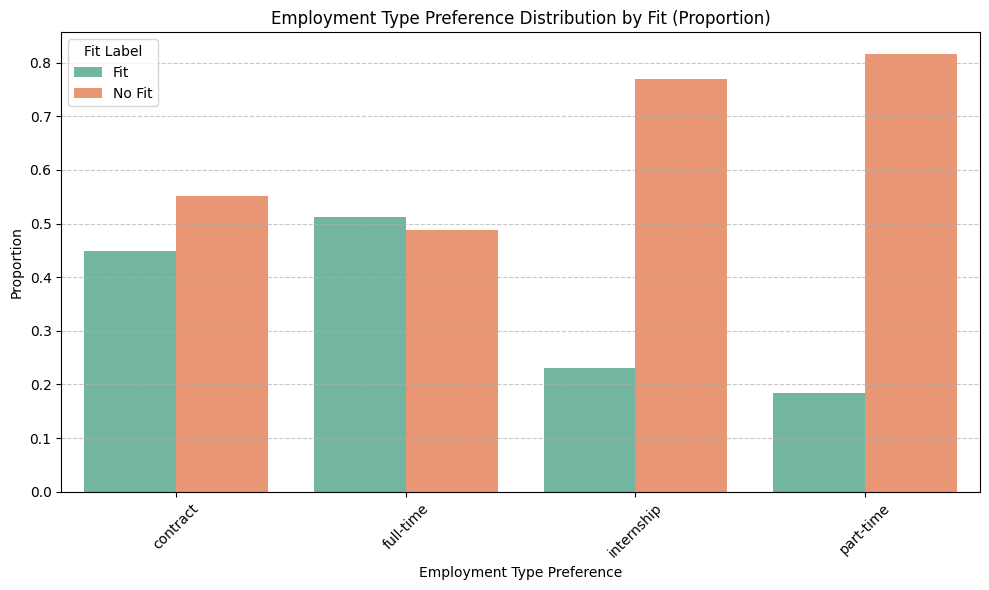

In [370]:
# Group and count the data
group_counts = df_jd_label_joined.groupby(['employment_type_cleaned', 'fit_grouped']).size().reset_index(name='counts')

# Calculate total counts per employment type
total_counts = group_counts.groupby('employment_type_cleaned')['counts'].transform('sum')

# Calculate ratio
group_counts['ratio'] = group_counts['counts'] / total_counts

# Plot ratio with seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=group_counts,
            x='employment_type_cleaned',
            y='ratio',
            hue='fit_grouped',
            palette='Set2')

plt.title('Employment Type Preference Distribution by Fit (Proportion)')
plt.xlabel('Employment Type Preference')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit Label')
plt.tight_layout()
plt.show()


#### job_location      

In [329]:
location_lookup = {}
us_country_code = 'US'  # Focus on US states only (data too dirty for now. future prompt engineering is needed)
country_codes = set(city_state_df['country_code'].dropna().unique())

# Build location lookup dictionary for US states only
for idx, row in city_state_df.iterrows():
    if row['country_code'] != us_country_code:  # Skip non-US rows
        continue

    city_name = str(row['name']).strip().lower() if pd.notna(row['name']) else None
    state_code = str(row['state_code']).strip().lower() if pd.notna(row['state_code']) else None
    state_name = str(row['state_name']).strip().lower() if pd.notna(row['state_name']) else None

    if state_code:
        location_lookup[state_code] = row['state_code'] 
    if state_name:
        location_lookup[state_name] = row['state_code']
    if city_name:
        location_lookup[city_name] = row['state_code']


In [330]:
def standardize_location(location_str):
    if pd.isna(location_str):
        return 'Not specified'

    loc = location_str.strip().lower()
    parts = re.split(r',|\bor\b|\/|\band\b', loc)  # split by , or / or and

    for part in parts:
        part = part.strip()
        
        # Skip if the part matches a known country code (like 'UK', 'UA')
        if part.upper() in country_codes:
            continue  

        # Check if the part matches the lookup
        if part in location_lookup:
            return location_lookup[part]

    return 'Not specified'

In [331]:
# Apply to dataframe
df_jd_label_joined['job_location_standardized'] = df_jd_label_joined['job_location'].apply(standardize_location)


In [332]:
print("Unique Original Locations:")
print(sorted(df_jd_label_joined['job_location'].dropna().unique()))

print("\nUnique Standardized Locations:")
print(sorted(df_jd_label_joined['job_location_standardized'].unique()))



Unique Original Locations:
['100% Remote', '100% Remote, EST Time Zone', '701 W 51st St, Austin, TX 78751', '701 W 51st St, Austin, TX 78751 (Remote work within the state of Texas)', '701 W 51st St, Austin, TX 78751 (with remote work options within the state of Texas)', '701 W 51st St, Austin, TX 78751 (with remote work within the state of Texas)', 'Absecon (Hybrid)', 'Ada MI', 'Ada, MI', 'Aliso Viejo, CA', 'Allentown', 'Alpharetta, GA (Hybrid)', 'Alpharetta, GA (Hybrid: 3 days in office, 2 days home)', 'Annapolis, Maryland', 'Atlanta, GA', 'Atlanta, GA (Hybrid)', 'Atlanta, GA (Onsite Role)', 'Atlanta, GA (Onsite)', 'Austin, TX; Irving, TX; Fort Myers, FL', 'Austin, TX; Irving, TX; Fort Myers, FL; Hybrid', 'Bellevue, USA', 'Bentonville, AR or Dallas, TX', 'Berkeley, California', 'Blandon, PA', 'Boonton, NJ', 'Boston, MA (Remote)', 'Canada', 'Carol Stream, IL, Milwaukee, WI and Appleton, WI', 'Carol Stream, IL, Milwaukee, WI, Appleton, WI', 'Chicago, IL', 'Chicago, IL (Hybrid on-site, i

In [38]:
from utils.data_cleaning_utils import location_lookup, standardize_location_column

location_pref_counts = df_jd_label_joined.groupBy("job_location").agg(
    count("*").alias("count")
)

print("Location Type Preference Counts:")
location_pref_counts.show()

city_state_list = r'datamart/bronze/location/cities.csv'
city_state_df = pd.read_csv(city_state_list)
print(city_state_df.head(5))


location_dict = location_lookup(city_state_df)


Location Type Preference Counts:
+--------------------+-----+
|        job_location|count|
+--------------------+-----+
|Fully-remote (Uni...|    2|
|Waltham, MA (Hybrid)|   29|
|          Duluth, GA|    8|
|             On-site|    6|
|         Malvern, PA|    6|
|Bentonville, AR o...|   12|
|Onsite - Miami, F...|    2|
|New York City or ...|    9|
|hybrid, North Dal...|    2|
|         Boonton, NJ|   19|
|Menomonee Falls (...|   15|
|Chicago, IL (Hybr...|    1|
|           Allentown|   27|
|Gilbert, AZ (on-s...|    8|
|Remote; Los Angel...|    5|
|      Huntsville, AL|    7|
|Atlanta, GA (Onsi...|    8|
|Nashville, TN (Re...|    6|
|              Remote|  447|
|San Francisco (Hy...|    7|
+--------------------+-----+
only showing top 20 rows

    id       name  state_id state_code  state_name  country_id country_code  \
0   52  Ashkāsham      3901        BDS  Badakhshan           1           AF   
1   68   Fayzabad      3901        BDS  Badakhshan           1           AF   
2   78  

In [40]:
df_jd_label_joined = standardize_location_column(
    df_jd_label_joined,
    location_col="job_location",
    location_lookup=location_dict,
)

print("Unique Original Locations:")
original_locations = df_jd_label_joined.select("job_location") \
    .where(col("job_location").isNotNull()) \
    .distinct() \
    .orderBy("job_location") \
    .rdd.flatMap(lambda x: x) \
    .collect()
print(original_locations)

print("\nUnique Standardized Locations:")
standardized_locations = df_jd_label_joined.select("job_location_cleaned") \
    .where(col("job_location_cleaned").isNotNull()) \
    .distinct() \
    .orderBy("job_location_cleaned") \
    .rdd.flatMap(lambda x: x) \
    .collect()
print(standardized_locations)

Unique Original Locations:
['100% Remote', '100% Remote, EST Time Zone', '701 W 51st St, Austin, TX 78751', '701 W 51st St, Austin, TX 78751 (Remote work within the state of Texas)', '701 W 51st St, Austin, TX 78751 (with remote work options within the state of Texas)', '701 W 51st St, Austin, TX 78751 (with remote work within the state of Texas)', 'Absecon (Hybrid)', 'Ada MI', 'Ada, MI', 'Aliso Viejo, CA', 'Allentown', 'Alpharetta, GA (Hybrid)', 'Alpharetta, GA (Hybrid: 3 days in office, 2 days home)', 'Annapolis, Maryland', 'Atlanta, GA', 'Atlanta, GA (Hybrid)', 'Atlanta, GA (Onsite Role)', 'Atlanta, GA (Onsite)', 'Austin, TX; Irving, TX; Fort Myers, FL', 'Austin, TX; Irving, TX; Fort Myers, FL; Hybrid', 'Bellevue, USA', 'Bentonville, AR or Dallas, TX', 'Berkeley, California', 'Blandon, PA', 'Boonton, NJ', 'Boston, MA (Remote)', 'Canada', 'Carol Stream, IL, Milwaukee, WI and Appleton, WI', 'Carol Stream, IL, Milwaukee, WI, Appleton, WI', 'Chicago, IL', 'Chicago, IL (Hybrid on-site, i

/tmp/ipykernel_14/3082653122.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', num_classes)  # Use Set1 colormap


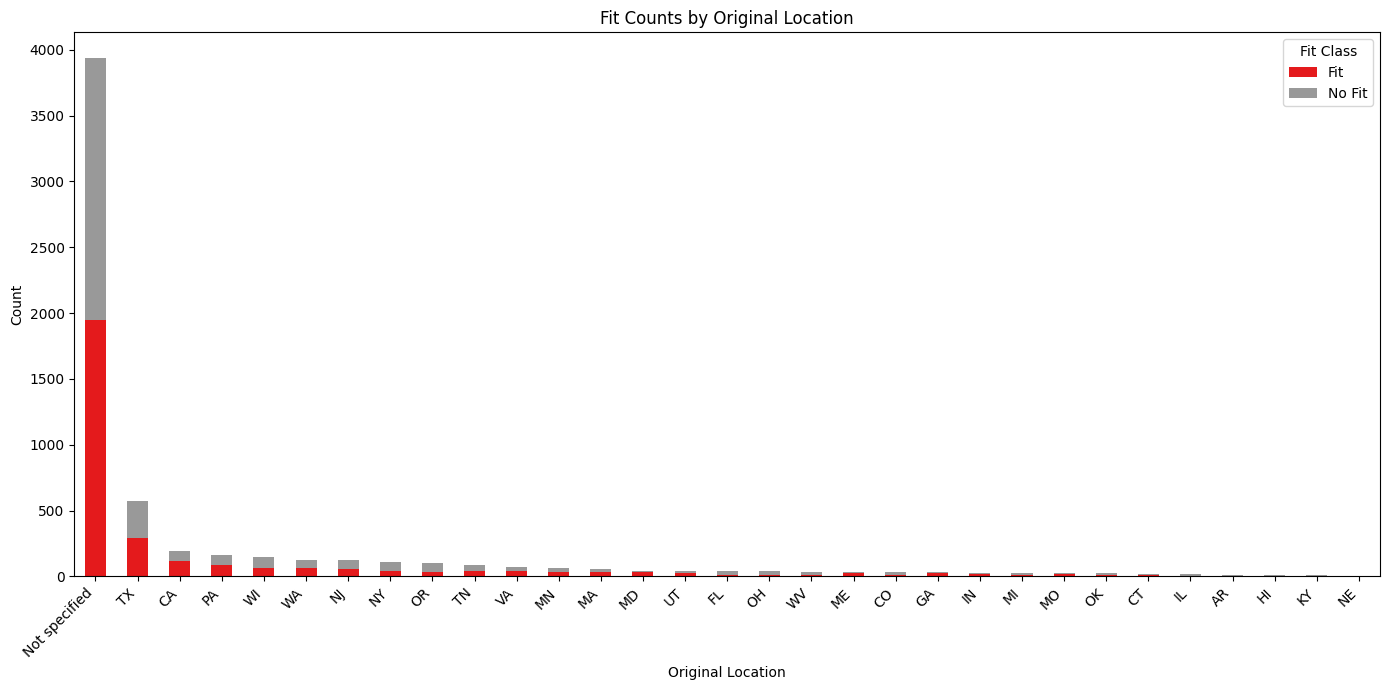

In [368]:
fit_counts = df_jd_label_joined.groupby(['job_location_standardized', 'fit_grouped']).size().unstack(fill_value=0)

# Sort locations by total counts (optional)
fit_counts['total'] = fit_counts.sum(axis=1)
fit_counts = fit_counts.sort_values('total', ascending=False)

fit_classes = fit_counts.columns.drop('total')
num_classes = len(fit_classes)

cmap = cm.get_cmap('Set1', num_classes)  # Use Set1 colormap
colors = [cmap(i) for i in range(num_classes)]

fit_counts[fit_classes].plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    color=colors
)

plt.xlabel('Original Location')
plt.ylabel('Count')
plt.title('Fit Counts by Original Location')
plt.legend(title='Fit Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_14/3943499789.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', num_classes)


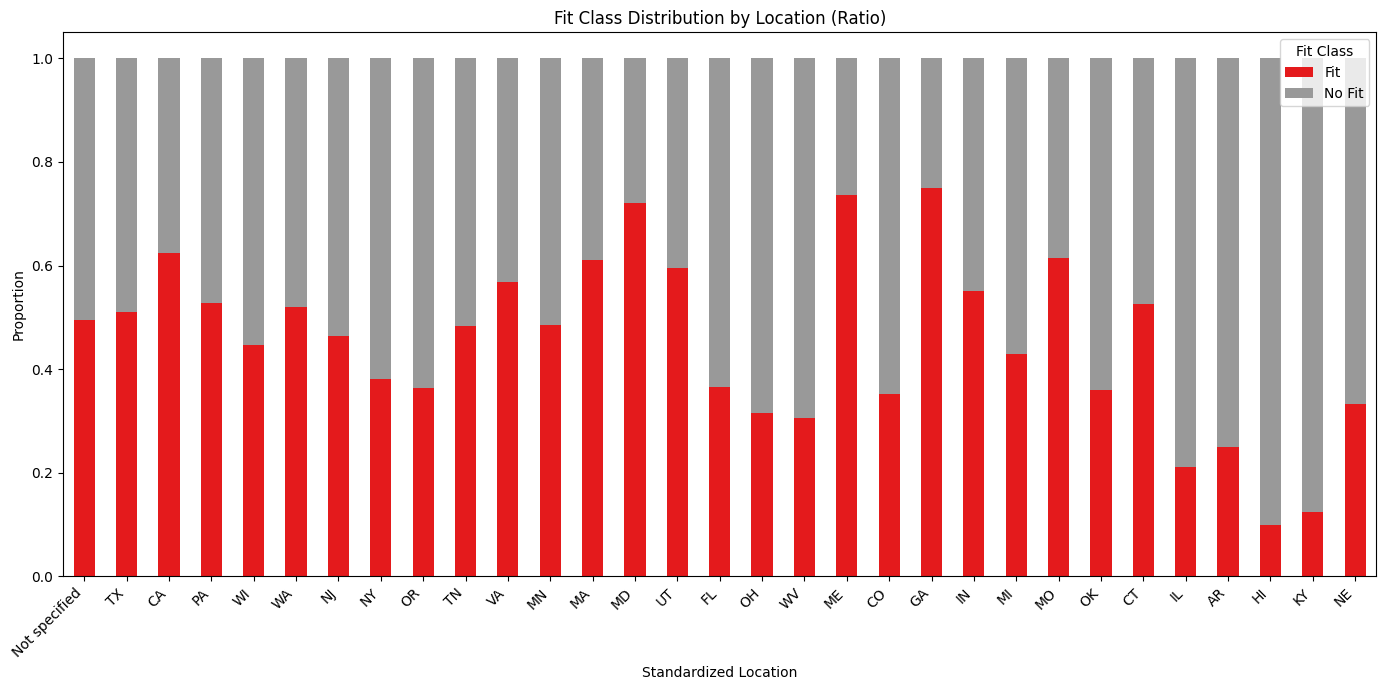

In [367]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fit_counts = df_jd_label_joined.groupby(['job_location_standardized', 'fit_grouped']).size().unstack(fill_value=0)

fit_counts['total'] = fit_counts.sum(axis=1)
fit_counts = fit_counts.sort_values('total', ascending=False)

fit_classes = fit_counts.columns.drop('total')

# Normalize each row to sum to 1 (ratio)
fit_ratios = fit_counts[fit_classes].div(fit_counts['total'], axis=0)

num_classes = len(fit_classes)
cmap = cm.get_cmap('Set1', num_classes)
colors = [cmap(i) for i in range(num_classes)]

fit_ratios.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    color=colors
)

plt.xlabel('Standardized Location')
plt.ylabel('Proportion')
plt.title('Fit Class Distribution by Location (Ratio)')
plt.legend(title='Fit Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### required work authorization 

In [349]:
work_auth_counts = df_jd_label_joined['required_work_authorization'].value_counts(dropna=False)
print("Work Authorization Counts:")
print(work_auth_counts)



Work Authorization Counts:
required_work_authorization
None                                                                                                                               5100
W2                                                                                                                                   99
Local to Michigan                                                                                                                    85
VISA INDEPENDENT ONLY                                                                                                                75
Authorized to work in the United States (excluding California)                                                                       66
                                                                                                                                   ... 
United States                                                                                                                    

In [347]:
def standardize_work_authorization(x):
    if pd.isna(x) or str(x).strip().lower() == 'none':
        return 'not needed'

    x_str = str(x).lower()

    # Common phrases meaning no sponsorship needed
    no_sponsor_patterns = [
        r'do\s*not\s*require',
        r'none',
    ]

    for pattern in no_sponsor_patterns:
        if re.search(pattern, x_str):
            return 'not needed'

    # Otherwise, treat as needing sponsorship or work auth
    return 'needed'


In [350]:
# Apply to your DataFrame
df_jd_label_joined['required_work_authorization_cleaned'] = df_jd_label_joined['required_work_authorization'].apply(standardize_work_authorization)

# Check result
work_auth_counts_cleaned = df_jd_label_joined['required_work_authorization_cleaned'].value_counts()
print("Standardized Work Authorization Counts:")
print(work_auth_counts_cleaned)


Standardized Work Authorization Counts:
required_work_authorization_cleaned
not needed    5108
needed        1133
Name: count, dtype: int64


In [44]:
from pyspark.sql.functions import coalesce, lit

df_filled = df_jd_label_joined.withColumn(
    "required_work_authorization",
    coalesce(col("required_work_authorization"), lit("null"))
)

work_auth_counts = df_filled.groupBy("required_work_authorization").count()

print("Work Authorization Counts:")
work_auth_counts.orderBy("count", ascending=False).show(truncate=False)




Work Authorization Counts:
+------------------------------------------------------------------------------------------------------+-----+
|required_work_authorization                                                                           |count|
+------------------------------------------------------------------------------------------------------+-----+
|null                                                                                                  |5100 |
|W2                                                                                                    |99   |
|Local to Michigan                                                                                     |85   |
|VISA INDEPENDENT ONLY                                                                                 |75   |
|Authorized to work in the United States (excluding California)                                        |66   |
|US Citizenship or Authorization to work in US                                       

In [46]:
from utils.data_cleaning_utils import clean_work_authorization_column

df_jd_label_joined = clean_work_authorization_column(df_jd_label_joined, "required_work_authorization")

# Count and show the standardized work authorization values
work_auth_counts_cleaned = df_jd_label_joined.groupBy("required_work_authorization").count()

print("Standardized Work Authorization Counts:")
work_auth_counts_cleaned.orderBy("count", ascending=False).show(truncate=False)

Standardized Work Authorization Counts:


[Stage 183:>                                                        (0 + 1) / 1]

+------------------------------------------------------------------------------------------------------+-----+
|required_work_authorization                                                                           |count|
+------------------------------------------------------------------------------------------------------+-----+
|NULL                                                                                                  |5100 |
|W2                                                                                                    |99   |
|Local to Michigan                                                                                     |85   |
|VISA INDEPENDENT ONLY                                                                                 |75   |
|Authorized to work in the United States (excluding California)                                        |66   |
|US Citizenship or Authorization to work in US                                                         |65   |
|

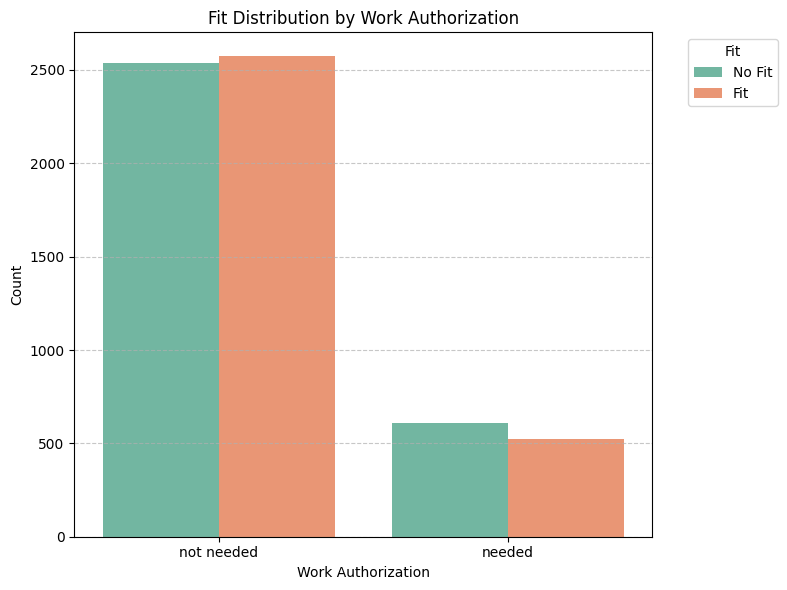

In [364]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.countplot(
    data=df_jd_label_joined,
    x='required_work_authorization_cleaned',
    hue='fit_grouped',   # shows counts split by 'fit'
    palette='Set2'
)

plt.title('Fit Distribution by Work Authorization')
plt.xlabel('Work Authorization')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

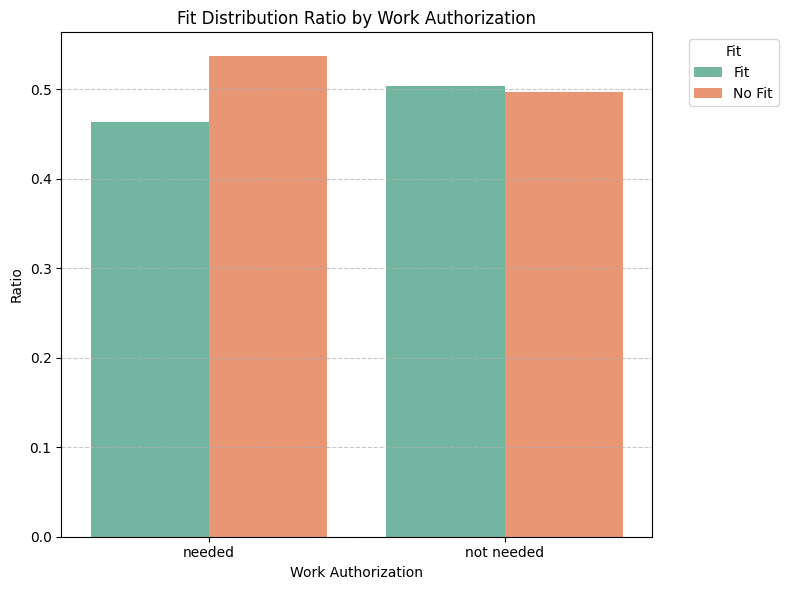

In [366]:
prop_df = (
    df_jd_label_joined
    .groupby(['required_work_authorization_cleaned', 'fit_grouped'])
    .size()
    .reset_index(name='count')
)

# Calculate total counts per work authorization group
total_counts = prop_df.groupby('required_work_authorization_cleaned')['count'].transform('sum')

# Calculate ratio within each group
prop_df['ratio'] = prop_df['count'] / total_counts

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=prop_df,
    x='required_work_authorization_cleaned',
    y='ratio',
    hue='fit_grouped',
    palette='Set2'
)

plt.title('Fit Distribution Ratio by Work Authorization')
plt.xlabel('Work Authorization')
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Skill Keywords

In [387]:
# Join tables based on element ID for skills
# Load the tables
skills_df = pd.read_excel(r'datamart/bronze/skills/Skills.xlsx')
work_activities_df = pd.read_excel(r'datamart/bronze/skills/Skills to Work Activities.xlsx')

# Standardize the join column name to 'element_id'
skills_df = skills_df.rename(columns={"Element ID": "element_id"})
work_activities_df = work_activities_df.rename(columns={"Skills Element ID": "element_id"})

# Perform the inner join
skills_activity_df = skills_df.merge(work_activities_df, on="element_id", how="inner") \
                     .merge(work_context_df, on="element_id", how="inner")

# Select and rename columns
skills_activity_df = skills_activity_df[["element_id", "Element Name", "Work Activities Element Name"]].rename(
    columns={
        "element_id": "keyword_id",
        "Element Name": "keyword",
        "Work Activities Element Name": "examples"
    }
)

print(skills_activity_df.head())



  keyword_id                keyword  \
0    2.A.1.a  Reading Comprehension   
1    2.A.1.a  Reading Comprehension   
2    2.A.1.a  Reading Comprehension   
3    2.A.1.a  Reading Comprehension   
4    2.A.1.a  Reading Comprehension   

                                            examples  
0                                Getting Information  
1      Monitor Processes, Materials, or Surroundings  
2           Identifying Objects, Actions, and Events  
3  Judging the Qualities of Things, Services, or ...  
4                             Processing Information  


In [388]:
# Load the tables
skills_df = pd.read_excel(r'datamart/bronze/skills/Skills.xlsx')
work_context_df = pd.read_excel(r'datamart/bronze/skills/Skills to Work Context.xlsx')

# Standardize the join column name to 'element_id'
skills_df = skills_df.rename(columns={"Element ID": "element_id"})
work_context_df = work_context_df.rename(columns={"Skills Element ID": "element_id"})

# Perform the inner join
skills_context_df = skills_df.merge(work_activities_df, on="element_id", how="inner") \
                     .merge(work_context_df, on="element_id", how="inner")

# Select and rename columns
skills_context_df = skills_context_df[["element_id", "Element Name", "Work Context Element Name"]].rename(
    columns={
        "element_id": "keyword_id",
        "Element Name": "keyword",
        "Work Context Element Name": "examples"
    }
)

print(skills_context_df.head())



  keyword_id                keyword         examples
0    2.A.1.a  Reading Comprehension  Electronic Mail
1    2.A.1.a  Reading Comprehension  Electronic Mail
2    2.A.1.a  Reading Comprehension  Electronic Mail
3    2.A.1.a  Reading Comprehension  Electronic Mail
4    2.A.1.a  Reading Comprehension  Electronic Mail


In [389]:
# Append the two DataFrames
combined_df = pd.concat([skills_activity_df, skills_context_df], ignore_index=True)

# Convert all string columns to lowercase
for col in combined_df.select_dtypes(include='object').columns:
    combined_df[col] = combined_df[col].str.lower()

print(combined_df.head())

print("\nskills_activity_df length:", len(skills_activity_df))
print("skills_context_df length:", len(skills_context_df))
print("combined_df length:", len(combined_df))

  keyword_id                keyword  \
0    2.a.1.a  reading comprehension   
1    2.a.1.a  reading comprehension   
2    2.a.1.a  reading comprehension   
3    2.a.1.a  reading comprehension   
4    2.a.1.a  reading comprehension   

                                            examples  
0                                getting information  
1      monitor processes, materials, or surroundings  
2           identifying objects, actions, and events  
3  judging the qualities of things, services, or ...  
4                             processing information  

skills_activity_df length: 2178162
skills_context_df length: 2178162
combined_df length: 4356324


In [390]:
tech_skills_path = r'datamart/bronze/skills/Technology Skills.xlsx'
tech_skills_df = pd.read_excel(tech_skills_path)

# Standardize column names if needed
tech_skills_df = tech_skills_df.rename(columns={
    "Commodity Code": "keyword_id",
    "Commodity Title": "keyword",
    "Example": "example"
})

# Keep only the required columns
tech_skills_df = tech_skills_df[["keyword_id", "keyword", "example"]]

# Lowercase all string columns
for col in tech_skills_df.select_dtypes(include='object').columns:
    tech_skills_df[col] = tech_skills_df[col].str.lower()

print(tech_skills_df.head())
print("tech_skills_df length:", len(tech_skills_df))

   keyword_id                                        keyword  \
0    43232202                   document management software   
1    43232306    data base user interface and query software   
2    43232201                      content workflow software   
3    43232303  customer relationship management crm software   
4    43231601                            accounting software   

                                example  
0           adobe systems adobe acrobat  
1                       adsense tracker  
2                        atlassian jira  
3           blackbaud the raiser's edge  
4  computerease construction accounting  
tech_skills_df length: 31078


In [404]:
SCOPES = ['https://www.googleapis.com/auth/drive']

creds = service_account.Credentials.from_service_account_file(
    'service_account.json',
    scopes=SCOPES
)

service = build('drive', 'v3', credentials=creds)

def get_or_create_folder(service, folder_name, parent_id):
    query = f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}' and trashed = false"
    if parent_id:
        query += f" and '{parent_id}' in parents"
    else:
        query += " and 'root' in parents"

    response = service.files().list(q=query, fields="files(id, name)").execute()
    files = response.get('files', [])
    
    if files:
        return files[0]['id']
    else:
        folder_metadata = {
            'name': folder_name,
            'mimeType': 'application/vnd.google-apps.folder',
        }
        if parent_id:
            folder_metadata['parents'] = [parent_id]
        folder = service.files().create(body=folder_metadata, fields='id').execute()
        return folder.get('id')

def get_folder_id_by_path(service, path_list, root_parent_id=None):
    parent_id = root_parent_id
    for folder_name in path_list:
        parent_id = get_or_create_folder(service, folder_name, parent_id)
    return parent_id


parent_root = '1_eMgnRaFtt-ZSZD3zfwai3qlpYJ-M5C6' 

soft_skill_path = ['datamart', 'silver', 'softskill']
final_soft_skill_id = get_folder_id_by_path(service, soft_skill_path, parent_root)
print("Final soft skill folder ID:", final_soft_skill_id)

hard_skill_path = ['datamart', 'silver',  'hardskill']
final_hard_skill_id = get_folder_id_by_path(service, hard_skill_path, parent_root)
print("Final hard skill folder ID:", final_hard_skill_id)


Final soft skill folder ID: 11yd5W_ng5rzlOuDljRuBXbTe5OCFMEed
Final hard skill folder ID: 1JhkeroB6NlqmrpY2Q6kNV2dRzkRLbiab


In [ ]:
# For hard skills (tech_skills_df)
tech_skills_local_path = 'Technology_Skills.parquet'
tech_skills_df.to_parquet(tech_skills_local_path, index=False)

# For soft skills (combined_df)
soft_skills_local_path = 'Soft_Skills_Combined.parquet'
combined_df.to_parquet(soft_skills_local_path, index=False)


In [ ]:
def upload_file_resumable(service, local_file_path, drive_folder_id, drive_file_name):
    file_metadata = {
        'name': drive_file_name,
        'parents': [drive_folder_id]
    }
    media = MediaFileUpload(local_file_path, mimetype='application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', resumable=True)

    request = service.files().create(body=file_metadata, media_body=media, fields='id, name')
    
    response = None
    while response is None:
        status, response = request.next_chunk()
        if status:
            print(f"Upload progress: {int(status.progress() * 100)}%")
    
    print(f"Uploaded file '{response.get('name')}' with ID: {response.get('id')}")
    return response.get('id')


In [ ]:
upload_file(service, 'Technology_Skills.parquet', final_hard_skill_id)
upload_file(service, 'Soft_Skills_Combined.parquet', final_soft_skill_id)


In [ ]:
def download_parquet_from_drive(service, file_id):
    request = service.files().get_media(fileId=file_id)
    fh = BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download progress: {int(status.progress() * 100)}%")

    fh.seek(0) 
    return fh


parquet_file_id = '1m8V7XyMbhOssQpJ5jk24FXtTQPoWE-a2'  

parquet_bytes = download_parquet_from_drive(service, parquet_file_id)

# Load Parquet file into Pandas DataFrame
df = pd.read_parquet(parquet_bytes, engine='pyarrow')

print(df.head())


## Label transformation 

In [357]:
df_silver_label = read_bronze_table_as_pandas("jobmirror_db", "bronze_labels")

df_silver_label.head(5)

,id,resume_id,job_id,fit,snapshot_date
0,LABEL_Lrgk1qIc,RES_Lrgk1qIc,JD_Lrgk1qIc,No Fit,2021-10-30
1,LABEL_kUoPlNoI,RES_kUoPlNoI,JD_kUoPlNoI,No Fit,2021-09-17
2,LABEL_s93wTCLp,RES_s93wTCLp,JD_s93wTCLp,No Fit,2021-07-15
3,LABEL_W35SEzlG,RES_W35SEzlG,JD_W35SEzlG,No Fit,2021-10-15
4,LABEL_kQiZZseA,RES_kQiZZseA,JD_kQiZZseA,No Fit,2021-06-16


In [361]:
def regroup_label(fit_value):
    if fit_value in ['Good Fit', 'Potential Fit']:
        return 'Fit'
    else:
        return fit_value

# Apply to your DataFrame column
df_jd_label_joined['fit_grouped'] = df_jd_label_joined['fit'].apply(regroup_label)


In [371]:
df_jd_label_joined['fit_grouped'] = df_jd_label_joined['fit'].apply(regroup_label)
df_resume_label_joined['fit_grouped'] = df_resume_label_joined['fit'].apply(regroup_label)


In [362]:
df_silver_label.head(5)

,id,resume_id,job_id,fit,snapshot_date,fit_grouped
0,LABEL_Lrgk1qIc,RES_Lrgk1qIc,JD_Lrgk1qIc,No Fit,2021-10-30,No Fit
1,LABEL_kUoPlNoI,RES_kUoPlNoI,JD_kUoPlNoI,No Fit,2021-09-17,No Fit
2,LABEL_s93wTCLp,RES_s93wTCLp,JD_s93wTCLp,No Fit,2021-07-15,No Fit
3,LABEL_W35SEzlG,RES_W35SEzlG,JD_W35SEzlG,No Fit,2021-10-15,No Fit
4,LABEL_kQiZZseA,RES_kQiZZseA,JD_kQiZZseA,No Fit,2021-06-16,No Fit


# GOLD

## Get scores

In [ ]:
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/text-embedding-004", task_type="SEMANTIC_SIMILARITY"
)

In [ ]:
embeddings_required_skills = embedding_model.embed_documents(parsed_jd.required_hard_skills)
embeddings_skills_owned = embedding_model.embed_documents(parsed_resume.hard_skills)

In [ ]:
required_skills = np.array(embeddings_required_skills)
skills_owned = np.array(embeddings_skills_owned)

# Normalize embeddings to unit vectors (L2 norm)
required_skills = required_skills / np.linalg.norm(required_skills, axis=1, keepdims=True)
skills_owned = skills_owned / np.linalg.norm(skills_owned, axis=1, keepdims=True)

# Compute cosine similarity matrix by dot product
similarity_matrix = np.dot(required_skills, skills_owned.T)

In [ ]:
best_matches = []

for i, req_skill in enumerate(parsed_jd.required_hard_skills):
    j = similarity_matrix[i].argmax()
    score = similarity_matrix[i, j]
    if score >= 0.6:
        best_matches.append((req_skill, parsed_resume.hard_skills[j], score))

# Print
for req_skill, own_skill, score in best_matches:
    print(f"Required: {req_skill}  <=> Best Owned: {own_skill}  | Similarity: {score:.2f}")

In [ ]:
embeddings_role_name = embedding_model.embed_query(parsed_jd.role_title)
embeddings_experience_titles = embedding_model.embed_documents([exp.role for exp in parsed_resume.experience])

In [ ]:
parsed_jd.role_title

In [ ]:
[exp.role for exp in parsed_resume.experience]

In [ ]:
role_name = np.array(embeddings_role_name)
experiences = np.array(embeddings_experience_titles)

# Normalize embeddings to unit vectors (L2 norm)
role_name = role_name / np.linalg.norm(role_name)
experiences = experiences / np.linalg.norm(experiences, axis=1, keepdims=True)

# Compute cosine similarity matrix by dot product
similarity_matrix = np.dot(experiences, role_name.T)

In [ ]:
similarity_matrix